In [45]:
import os
import sys
import shutil
import numpy as np
from sklearn.cluster import DBSCAN
from sklearn.metrics.pairwise import cosine_similarity
from tqdm import tqdm
import queue
import threading
import cv2

from facelib import FaceRecognizer, FaceDetector
from facelib import get_config
from matplotlib import pyplot as plt
from IPython.display import display
from PIL import Image  # For loading images


In [63]:
TEST_DIRECTORY = '/scratch/u1541638/Data-Mining-Spring-2025-Project/data/Taxi Driver B-Sample'
OUTPUT_DIRECTORY = '/home/u1541638/Projects/Data-Mining-Spring-2025-Project/data/Taxi Driver B-Sample/Output'
SCRATCH_OUTPUT_DIRECTORY = '/scratch/u1541638/Data-Mining-Spring-2025-Project/data/Taxi Driver B-Sample/Output'

In [47]:
def encode_faces_from_folder(folder_path):
    """
    Loads images from the given folder, detects faces using InsightFace,
    and returns the face embeddings along with their image paths.
    """
    embeddings = []
    image_paths = []
    no_face_count = 0
    
    conf = get_config()
    face_regonizer = FaceRecognizer(conf)
    face_detector = FaceDetector(name='resnet')

    filenames = os.listdir(folder_path)
    for filename in tqdm(filenames, desc=f"Encoding faces in {os.path.basename(folder_path)}"):
        if filename.lower().endswith(('.png', '.jpg', '.jpeg')):
            image_path = os.path.join(folder_path, filename)
            image = cv2.imread(image_path)
            if image is None:
                print(f"Failed to read image: {filename}")
                continue

            faces, boxes, scores, landmarks = face_detector.detect_align(image)
            if faces.numel() > 0:
                embs = face_regonizer.feature_extractor(faces)
                embeddings += embs.tolist()
                image_paths.append(image_path)
            else:
                no_face_count += 1  # Increment the counter
                # print(f"No face detected in {filename}")
                
    print(f"{folder_path}. All files_count {len(filenames)}. No faces detected in {no_face_count} images.")

    return np.array(embeddings), image_paths


In [48]:
def cluster_faces_dbscan(embeddings, eps=0.3, min_samples=2):
    """
    Clusters face embeddings using DBSCAN with cosine distance.
    """
    cosine_similarities = cosine_similarity(embeddings)
    print(f"Min cosine similarity: {np.min(cosine_similarities)}")
    print(f"Max cosine similarity: {np.max(cosine_similarities)}")

    cosine_distances = 1 - cosine_similarities
    cosine_distances = np.maximum(0, cosine_distances)
    cosine_distances = np.nan_to_num(cosine_distances, nan=1.0)

    dbscan = DBSCAN(metric="precomputed", eps=eps, min_samples=min_samples)
    labels = dbscan.fit_predict(cosine_distances)
    return labels



In [49]:
def save_clustered_images(image_paths, labels, output_folder):
    """
    Copies images into subfolders based on their cluster labels.
    """
    if not os.path.exists(output_folder):
        os.makedirs(output_folder)

    for img_path, cluster in zip(image_paths, labels):
        cluster_folder = os.path.join(output_folder, f"cluster_{cluster}")
        if not os.path.exists(cluster_folder):
            os.makedirs(cluster_folder)
        shutil.copy(img_path, os.path.join(cluster_folder, os.path.basename(img_path)))


In [53]:
print(f"\nProcessing folder: {TEST_DIRECTORY}")
embeddings, image_paths = encode_faces_from_folder(TEST_DIRECTORY)




Processing folder: /scratch/u1541638/Data-Mining-Spring-2025-Project/data/Taxi Driver B-Sample


Encoding faces in Taxi Driver B-Sample: 100%|██████████| 178/178 [00:02<00:00, 82.43it/s]

/scratch/u1541638/Data-Mining-Spring-2025-Project/data/Taxi Driver B-Sample. All files_count 178. No faces detected in 50 images.


In [54]:
embeddings.shape

(128, 512)

In [59]:
labels = cluster_faces_dbscan(embeddings, eps=0.5, min_samples=3)


Min cosine similarity: -0.20306200196726
Max cosine similarity: 1.0000000000000013



Cluster 0:


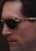

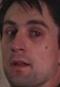

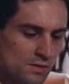

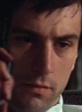

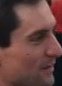


Cluster 1:


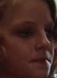

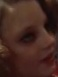

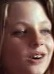

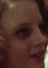

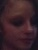


Cluster 2:


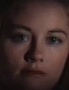

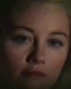

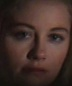


Cluster 3:


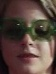

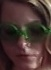

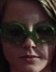

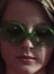

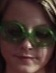


Cluster 4:


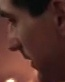

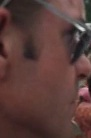

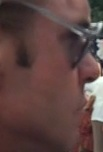

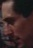

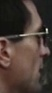

In [60]:
# Group images into clusters
clusters = {}
for img_path, cluster in zip(image_paths, labels):
    if cluster not in clusters:
        clusters[cluster] = []
    clusters[cluster].append(img_path)
    
def display_clusters(clusters):
    for cluster, images in clusters.items():
        if cluster == -1:
            continue
        print(f"\nCluster {cluster}:")
        if images:  # Ensure the list is not empty
            for image in images[:5]:
                img = Image.open(image)  # Load first image
                display(img)  # Show image

display_clusters(clusters)

In [66]:
save_clustered_images(image_paths, labels, OUTPUT_DIRECTORY)
print(f"Clustered images saved in: {OUTPUT_DIRECTORY}")


Clustered images saved in: /home/u1541638/Projects/Data-Mining-Spring-2025-Project/data/Taxi Driver B-Sample/Output


In [65]:
save_clustered_images(image_paths, labels, SCRATCH_OUTPUT_DIRECTORY)
print(f"Clustered images saved in: {SCRATCH_OUTPUT_DIRECTORY}")


Clustered images saved in: /scratch/u1541638/Data-Mining-Spring-2025-Project/data/Taxi Driver B-Sample/Output
